In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from simdec import decomposition, palette, sensitivity_indices, states_expansion, tableau, visualization

In [2]:
df = pd.read_csv('data/xgboost_tutorial_data.csv')

In [34]:
list(df.columns)

['last_name, first_name',
 'player_id',
 'year',
 'pa',
 'home_run',
 'k_percent',
 'bb_percent',
 'woba',
 'xwoba',
 'sweet_spot_percent',
 'barrel_batted_rate',
 'hard_hit_percent',
 'avg_best_speed',
 'avg_hyper_speed',
 'whiff_percent',
 'swing_percent']

In [5]:
y = df['woba']
X = df[[
    'pa',
    'home_run',
    'k_percent',
    'bb_percent',
    'sweet_spot_percent',
    'avg_best_speed',
    'swing_percent'
]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 2002,
    stratify = None
) # train test split
print(f"Number of training set players: {X_train.shape[0]}")
print(f"Number of test set players: {X_test.shape[0]}")

Number of training set players: 264
Number of test set players: 66


In [6]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=2002,
    eval_metric='rmse'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [9]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("Model Performance Metrics")
print(f"Variance explained by the model: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:{mae:.4f}")

Model Performance Metrics
Variance explained by the model: 0.5424
RMSE: 0.0237
MAE:0.0195


In [ ]:
y_pred = pd.DataFrame(y_pred) # transforming predictions to a dataframe

In [3]:
# creating target variable and inputs from actual data
output_name = df.columns[7] # woba is target variable
input_names = list(df.columns[3:7]) + list(df.columns[[9, 12, 15]])

inputs, output = df[input_names].copy(), df[output_name].copy()

inputs.head()

,pa,home_run,k_percent,bb_percent,sweet_spot_percent,avg_best_speed,swing_percent
0,535,10,12.3,10.5,38.0,96.497006,45.3
1,273,8,21.2,11.4,28.5,102.273063,43.8
2,683,50,25.3,15.4,34.5,106.186932,44.6
3,253,2,28.1,5.1,38.1,100.150408,50.4
4,402,10,10.0,7.0,30.2,97.276171,48.6


In [11]:
inputs.columns

Index(['pa', 'home_run', 'k_percent', 'bb_percent', 'sweet_spot_percent',
       'avg_best_speed', 'swing_percent'],
      dtype='object')

In [4]:
output.head()

0    0.326
1    0.275
2    0.416
3    0.286
4    0.286
Name: woba, dtype: float64

In [19]:
# computing sensitivity indices
indices = sensitivity_indices(inputs=inputs, output=output)

indices_df = pd.DataFrame({
    'variable': inputs.columns,
    'sensitivity_index': indices.si,
    'first_order': indices.first_order
})

# Calculate second-order effects (sum of interactions for each variable)
# This sums all interaction effects for each variable
second_order_sum = indices.second_order.sum(axis=1)

indices_df['second_order'] = second_order_sum

# Sort by sensitivity_index (descending)
indices_df = indices_df.sort_values('sensitivity_index', ascending=False).reset_index(drop=True)

print(indices_df)


             variable  sensitivity_index  first_order  second_order
0            home_run           0.485488     0.462457      0.046061
1      avg_best_speed           0.431599     0.261892      0.339415
2          bb_percent           0.412513     0.285156      0.254714
3                  pa           0.349426     0.247086      0.204681
4  sweet_spot_percent           0.252816     0.120347      0.264938
5           k_percent           0.051095     0.029100      0.043990
6       swing_percent          -0.002589     0.057524     -0.120228


In [6]:
# decomposing the problem with SimDec
si = indices.si
res = decomposition(inputs=inputs, output=output, sensitivity_indices=si)
res

DecompositionResult(var_names=['home_run', 'avg_best_speed'], statistic=array([[0.28916923, 0.29589189, 0.28913333],
       [0.31075676, 0.31979167, 0.32314286],
       [0.33844444, 0.33508   , 0.35      ]]), bins=        0      1      2      3      4      5      6      7      8
0   0.243  0.286  0.275  0.326  0.342  0.284  0.323  0.345  0.416
1   0.289  0.302  0.355  0.286  0.294  0.338  0.336  0.310  0.308
2   0.309  0.259  0.275  0.308  0.265  0.316  0.361  0.342  0.334
3   0.232  0.333  0.228  0.292  0.321  0.325  0.307  0.347  0.350
4   0.260  0.269  0.274  0.327  0.323  0.319  0.372  0.326  0.354
..    ...    ...    ...    ...    ...    ...    ...    ...    ...
61  0.319    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.393
62  0.229    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.348
63  0.322    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.329
64  0.252    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.331
65    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

In [7]:
palette = palette(states=res.states)[::-1]
palette

[[0.0702614379084967, 0.43562091503267975, 0.41353874883286645, 1.0],
 [0.14901960784313728, 0.8627450980392157, 0.8196078431372549, 1.0],
 [0.5846405228758169, 0.9330065359477124, 0.9119514472455649, 1.0],
 [0.4956417501498417, 0.5004538059765391, 0.050526586180323685, 1.0],
 [0.9098039215686274, 0.9176470588235294, 0.1843137254901961, 1.0],
 [0.9651425635756488, 0.9681736450038532, 0.6847675314667352, 1.0],
 [0.43562091503267975, 0.0702614379084967, 0.24892623716153087, 1.0],
 [0.8627450980392157, 0.14901960784313728, 0.4980392156862745, 1.0],
 [0.9330065359477124, 0.5846405228758169, 0.7549953314659192, 1.0]]

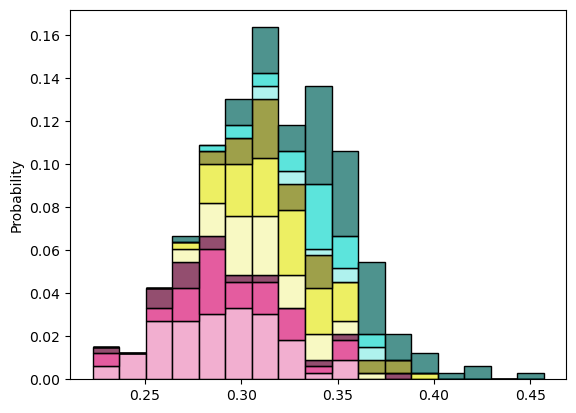

In [8]:
fig, ax = plt.subplots()
ax = visualization(bins=res.bins, palette=palette, ax=ax)

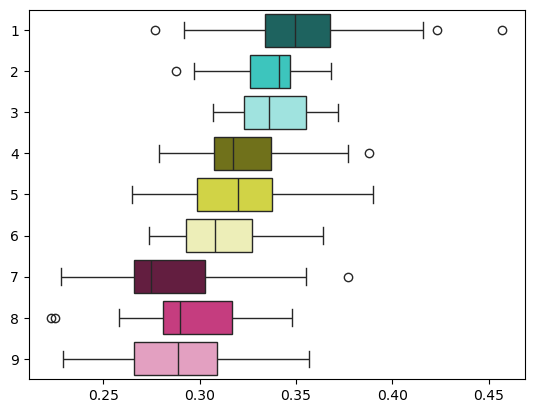

In [9]:
fig, ax = plt.subplots()
ax = visualization(bins=res.bins, palette=palette, kind="boxplot", ax=ax)

In [10]:
table, styler = tableau(
    statistic=res.statistic,
    var_names=res.var_names,
    states=res.states,
    bins=res.bins,
    palette=palette,
)
styler